<a href="https://colab.research.google.com/github/hfarruda/deeplearningtutorial/blob/master/deepLearning_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Generative Adversarial Networks
This example is part of the [*Deep Learning Tutorial*](https://github.com/hfarruda/deeplearningtutorial), authored by Henrique F. de Arruda, Alexandre Benatti, César Comin, and Luciano da Fontoura Costa. This code is not suitable for other data and/or applications, which will require modifications in the structure and parameters. This code has absolutely no warranty.

If you publish a paper related on this material, please cite:

H. F. de Arruda, A. Benatti, C. H. Comin, L. da F. Costa, "Learning Deep Learning (CDT-15)," 2019.

It was elaborated to create a network that can generate handwritten characters automatically.


First of all, we import the necessary libraries. Here we opt for using Keras (using TensorFlow backend). 

In [1]:
%tensorflow_version 1.x
import numpy as np
import pandas as pd 
import keras
from keras.models import Sequential, model_from_json
from keras.utils.vis_utils import plot_model
from keras.datasets import mnist
from keras.layers import InputLayer, Dense, Flatten, Reshape, Input, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.regularizers import L1L2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import cv2 

TensorFlow 1.x selected.


Using TensorFlow backend.


If you have a GPU, you can use the following code to allocate processing into it.  Otherwise, proceed to (*).

In [2]:
import tensorflow as tf 
from keras import backend as K

print(K.tensorflow_backend._get_available_gpus())

number_of_cpu_cores = 8
config = tf.ConfigProto(device_count = {'GPU': 1 , 'CPU': number_of_cpu_cores}) 
session = tf.Session(config=config) 
keras.backend.set_session(session)

['/job:localhost/replica:0/task:0/device:GPU:0']


(*) In this example we used the MNIST database in which it is composed by grayscale images of the 10 handwritten digits. It is available at Keras library on [keras-datasets](https://keras.io/datasets/).

The following command is used to load the data set.

In [3]:
(train_data_raw, train_target_raw), (_, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Because this code consumes too much of processing time, here we considered only the zeros and ones.

In [4]:
train_data = [img for i, img in enumerate(train_data_raw) 
              if train_target_raw[i] == 0 or train_target_raw[i] == 1]
train_data = np.array(train_data)

In order to visualize a given figure, the following code can be executed.

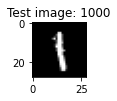

In [5]:
image_id = 1000
plt.figure(figsize = (1,1))
plt.imshow(train_data[image_id], cmap='gray')
plt.title("Test image: " + str(image_id))
#plt.axis('off')
plt.show()

Definition of the used variables.

In [6]:
input_shape = train_data.shape[1::]
activation_output_generator = 'sigmoid'
activation_output_discrimninator = 'sigmoid'
input_dim = 50
number_of_epochs = 1000
batch_size = 100
train_data = train_data.astype('float32') / 255

In the following, we present the generator model.

In [7]:
generator_model = Sequential()

generator_model.add(Dense(units=64,input_dim = input_dim, 
                          kernel_regularizer = L1L2(1e-5, 1e-5)))
generator_model.add(BatchNormalization())
generator_model.add(LeakyReLU(alpha=0.3))

generator_model.add(Dense(units=128, kernel_regularizer = L1L2(1e-5, 1e-5)))
generator_model.add(BatchNormalization())
generator_model.add(LeakyReLU(alpha=0.3))

generator_model.add(Dense(units=256, kernel_regularizer = L1L2(1e-5, 1e-5)))
generator_model.add(BatchNormalization())
generator_model.add(LeakyReLU(alpha=0.3))

generator_model.add(Dense(units = input_shape[0] * input_shape[1], 
                          activation = activation_output_generator))

generator_model.add(Reshape(input_shape))

generator_model.compile(loss='binary_crossentropy', optimizer="adam")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


The summary of the generator model is shown by employing the following code.

In [8]:
generator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                3264      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

The following code represents the discriminator model.

In [9]:
discriminator_model = Sequential()
discriminator_model.add(InputLayer(input_shape = input_shape))
discriminator_model.add(Flatten())

discriminator_model.add(Dense(units=256,kernel_regularizer = L1L2(1e-5, 1e-5)))
discriminator_model.add(LeakyReLU(alpha=0.3))
discriminator_model.add(Dropout(0.2))


discriminator_model.add(Dense(units=128,kernel_regularizer = L1L2(1e-5, 1e-5)))
discriminator_model.add(LeakyReLU(alpha=0.3))
discriminator_model.add(Dropout(0.2))

discriminator_model.add(Dense(units=64,kernel_regularizer = L1L2(1e-5, 1e-5)))
discriminator_model.add(LeakyReLU(alpha=0.3))

discriminator_model.add(Dense(units=1, 
                              activation = activation_output_discrimninator))

discriminator_model.compile(loss='binary_crossentropy', 
                            optimizer = "adam")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The summary of the discriminator model is shown by using the following code.

In [10]:
discriminator_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               200960    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

The following code incorporates the complete gan model.

In [11]:
gan_input = Input(shape = (input_dim,))
gan_output= discriminator_model(generator_model(gan_input))
gan = Model(inputs = gan_input, outputs = gan_output)
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')

The summary of the gan model is shown by using the following code.

In [12]:
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28)            247888    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 242177    
Total params: 490,065
Trainable params: 489,169
Non-trainable params: 896
_________________________________________________________________


Next, we train the GAN.

Epoch: 1 of 1000

/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


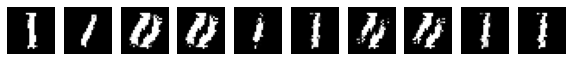

Epoch: 101 of 1000

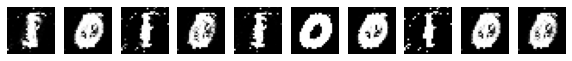

Epoch: 201 of 1000

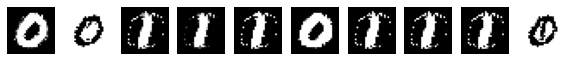

Epoch: 301 of 1000

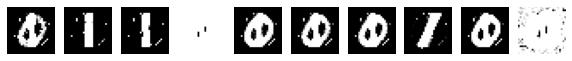

Epoch: 401 of 1000

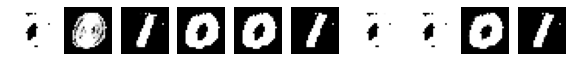

Epoch: 501 of 1000

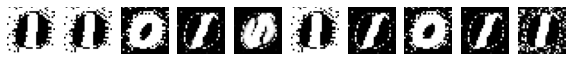

Epoch: 601 of 1000

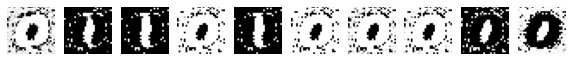

Epoch: 701 of 1000

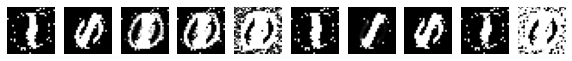

Epoch: 801 of 1000

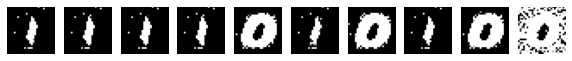

Epoch: 901 of 1000

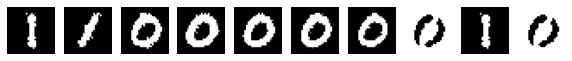

Epoch: 1000 of 1000


In [31]:
y = np.ones(batch_size)

#Parameters of the noise distribution
mu = 0
sigma = 1

#We created this array to avoid number repetitions
train_indices = np.arange(train_data.shape[0])
np.random.shuffle(train_indices)

#Here we define the labels used to train the gan
train_labels = np.zeros(2*batch_size,dtype = int)
train_labels[0:batch_size] = 1#generated images

for epoch in range(number_of_epochs):
    print("\rEpoch:", epoch + 1, "of", number_of_epochs, end = '')
    for _ in range(batch_size):
        input_noise = np.random.normal(loc = mu, scale = sigma, 
                                       size = [batch_size, input_dim])
        generated_images = generator_model.predict(input_noise)
        np.random.shuffle(train_indices)
        image_batch = train_data[train_indices[0:batch_size]]
        train_images = np.concatenate((image_batch, generated_images))
        #Training the discriminator
        discriminator_model.trainable = True
        discriminator_model.train_on_batch(train_images, train_labels)
        #Training the gan
        discriminator_model.trainable = False
        train_noise = np.random.normal(loc = mu, scale = sigma, 
                                       size =  [batch_size, input_dim])
        gan.train_on_batch(train_noise, y)

  #In order to visualize the training progress, we employ the following code.
    if epoch % 100 == 0:
        n_examples = 10
        scale_image = 1 * n_examples
        noise= np.random.normal(loc = mu, scale = sigma, 
                                size = (n_examples, input_dim))
        generated_images = generator_model.predict(noise)
        n_pixels = generated_images.shape[1]
        n_pixels_col = np.int(np.sqrt(n_pixels))
        fig, axes = plt.subplots(1,n_examples, 
                                 figsize = (scale_image, 
                                            scale_image * n_examples))
    for i in range(n_examples):
        axes[i].imshow(generated_images[i], cmap = "gray")
        axes[i].axis('off')
    plt.show()
print("")

In order to generate the figures the following code can be employed.

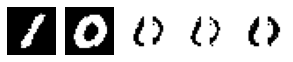

In [32]:
n_examples = 5
scale_image = 5
noise= np.random.normal(loc = mu, scale = sigma, size = (n_examples, input_dim))
generated_images = generator_model.predict(noise)

fig, axes = plt.subplots(1,n_examples,
                         figsize = (scale_image, scale_image * n_examples))
for i in range(generated_images.shape[0]):
    axes[i].imshow(generated_images[i], cmap = "gray")
    axes[i].axis('off')

plt.show()

## License

This Deep Learning Tutorial is licensed under a Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 (CC BY-NC-ND 4.0) International License.

## Acknowledgments
Henrique F. de Arruda acknowledges FAPESP for sponsorship (grant no. 2018/10489-0). Alexandre Benatti thanks Coordenação de Aperfeiçoamento de Pessoal de Nível Superior - Brasil (CAPES) - Finance Code 001. Luciano da F. Costa thanks CNPq (grant no. 307085/2018-0) and NAP-PRP-USP for sponsorship. César H. Comin thanks FAPESP (Grant Nos. 15/18942-8 and 18/09125-4) for financial support. This work has been supported also by FAPESP grants 11/50761-2 and 2015/22308-2.